In this notebook, we're going to demonstrate hyperparameter tuning for binary classification SCM model selection on synthetic data.

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../cadreModels')

from classificationBinary import binaryCadreModel

from sklearn.model_selection import train_test_split, KFold
from itertools import product
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style('darkgrid')

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/HealthINCITE/cadre/master/data/df_moderate.csv')
features = data.columns[data.columns.str.contains('cad|dv') & (data.columns != 'cadre')]

In [5]:
data.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,cadre,dv0,dv1,dv2,dv3,dv4,target
0,0.191442,2.266938,-1.571560,-1.000071,2.575162,0.809672,-0.158311,-1.647344,0.651466,-1.060883,0,4.784785,5.177201,-4.189262,5.070376,-4.898889,1
1,-1.174611,-0.395598,-0.436501,-0.606625,0.391813,0.092166,-0.008130,1.103397,0.112093,1.117736,0,-6.783252,-4.636362,4.250647,4.624133,-5.060853,0
2,-0.415574,0.968346,0.047912,-1.216676,0.695269,-0.188202,-0.665783,2.152114,0.284394,2.169629,0,-5.179748,-4.222403,-3.925779,5.182969,-5.919294,1
3,-0.785389,0.113480,-0.186819,-0.233704,0.014695,0.727447,0.543753,2.427905,-0.961922,-0.103388,0,6.143124,4.980376,-4.985737,5.742185,-4.723161,1
4,0.377902,1.359901,0.563633,0.511998,0.411057,-0.110674,0.204616,-0.375118,0.165277,-0.627823,0,3.798002,6.331110,-5.460732,5.288602,-4.742962,1


In [6]:
features

Index(['cad0', 'cad1', 'cad2', 'cad3', 'cad4', 'cad5', 'cad6', 'cad7', 'cad8',
       'cad9', 'dv0', 'dv1', 'dv2', 'dv3', 'dv4'],
      dtype='object')

Overall training-testing split.

In [7]:
D_tr, D_te = train_test_split(data, test_size=0.2, random_state=313616)

Functions for standardization

In [8]:
def standardize_col(col, mean, std):
    return (col - mean) / std

In [9]:
def standardizer(d_tr, d_va, features, d_te=None):
    d_tr_scale = d_tr.copy()
    d_va_scale = d_va.copy()
    if d_te is not None:
        d_te_scale = d_te.copy()
    for feature in features:
        f_mean = d_tr[feature].mean()
        f_std = d_tr[feature].std()
        
        d_tr_scale[feature] = standardize_col(d_tr_scale[feature], f_mean, f_std)
        d_va_scale[feature] = standardize_col(d_va_scale[feature], f_mean, f_std)
        if d_te is not None:
            d_te_scale[feature] = standardize_col(d_te_scale[feature], f_mean, f_std)
        
    if d_te is not None:
        return d_tr_scale, d_va_scale, d_te_scale
    else:
        return d_tr_scale, d_va_scale

These are the possible hyperparameter configurations we are going to search over.

In [10]:
l_ds = np.array([0.1, 0.01, 0.001])
l_Ws = np.array([0.1, 0.01, 0.001])
Ms = np.array([2,3,4,5,6])
n_folds = 5

A `binaryCadreModel`'s initialization function takes the following arguments and default values:

* `M=2` -- number of cadres in model
* `gamma=10.` -- cadre-assignment sharpness
* `lambda_d=0.01` -- regularization strength for cadre-assignment weight parameter `d`
* `lambda_W=0.01` -- regularization strength for classification-weight parameter `W`
* `alpha_d=0.9` -- elastic net mixing weight for cadre-assignment weight parameter `d`
* `alpha_W=0.9` -- elastic net mixing with for classification-weight parameter `W`
* `Tmax=10000` -- maximum number of SGD steps to take
* `record=100` -- during training, how often goodness-of-fit metrics should be evaluated on the data
* `eta=2e-3` -- initial stepsize / learning rate
* `Nba=64` -- minibatch size
* `eps=1e-3` -- convergence tolerance
* `termination_metric='ROC_AUC'` -- training terminated if the difference between the most recent `termination_metric` value and the second most recent `termination_metric` is less than `eps`

Note that `Tmax`'s default value is quite large. The number of SGD steps needed for training tends to vary wildly by dataset. Sometimes, only a few hundred are needed. Because of the convergence tolerance `eps`, if you specify too large a `Tmax`, the training will stop after progress slows.

Once you initialize a `binaryCadreModel`, you apply the `fit` method to train it. This method takes the following arguments and default values:

* `data` -- `pd.DataFrame` of training data
* `targetCol` -- string column-name of target feature in `data`
* `cadreFts=None` -- `pd.Index` of column-names used for cadre-assignment
* `predictFts=None` -- `pd.Index` of column-names used for target-prediction
* `dataVa=None` -- optional `pd.DataFrame` of validation data 
* `seed=16162` -- seed for parameter initialization and minibatch generation
* `store=False` -- whether or not copies `data` and `dataVa` should be added as attributes of the `binaryCadreModel`
* `progress=False` -- whether or not goodness-of-fit metrics should be printed during training
* `inits=None` -- a `dict` with keys from the subset of `{'C', 'd', 'W', 'W0'}` and entries as `numpy.array` used as specific initialization values for the matching SCM parameter

For `inits`, if, e.g., `inits={'d': np.array([1,2])}`, then, in the SCM learning problem, the parameter `d` will be initialized at the value of `np.array([1,2])` instead of to random values. You can use the `inits` argument to implement specific initialization strategies, via, e.g., $K$-means + logistic regression.

This function is applied in parallel for cross-validation model training.

Arguments (in relation to the initialization of a `binaryCadreModel` and its `fit` method:
* `d_tr` -- maps to `data
* `d_va` -- maps to `dataVa`
* `d_te` -- `pd.DataFrame` of testing data
* `M` -- maps to `M`
* `l_W` -- maps to `lambda_W`
* `l_d` -- maps to `lambda_d`
* `cadre_fts` -- maps to `cadreFts`
* `predict_fts` -- maps to `predictFts`
* `Tmax` -- maps to `Tmax`
* `record` -- maps to `record

The `scmCrossVal` function returns the trained SCM, as well as `pd.DataFrame`s giving goodness-of-fit metrics on the validaiton and testing data.

In [11]:
def scmCrossval(d_tr, d_va, d_te, M, l_W, l_d, cadre_fts, predict_fts, Tmax, record):
    mod = binaryCadreModel(
                Tmax=Tmax, record=record,
                M=M, alpha_d=0.99, alpha_W=0.99, lambda_d=l_d, lambda_W=l_W, gamma=10.)
    features = cadre_fts.union(predict_fts)
    ## standardize data
    d_tr_sc, d_va_sc, d_te_sc = standardizer(d_tr, d_va, features, d_te)
        
    mod.fit(d_tr_sc, 'target', cadre_fts, predict_fts, d_va_sc, progress=False)
    
    ## evaluate on validation and test sets
    err_va = mod.scoreMetrics(d_va_sc)
    err_te = mod.scoreMetrics(d_te_sc)
    
    ## return everything as a list
    return mod, err_va, err_te

Other attributes of the `binaryCadreModel` include:

* `W` -- matrix of cadre-specific classification weights
* `W0` -- vector of cadre-specific classification biases
* `C` -- matrix of cadre centers
* `d` -- vector of cadre-assignments weights
* `metrics` -- a `dict` with `'training'` and `'validation'` as keys. Each item is a `pd.DataFrame` of goodness-of-fit metrics evaluated during training. Metrics include loss, accuracy, ROC AUC, and precision-recall (PR) AUC
* `time` -- list of computer-time values it took for each SGD step to be evaluated
* `proportions` -- during training, the proportion of the training data assigned to each cadre is recorded. This is a `pd.DataFrame` of those proportions, which lets you see if cadre assignments have converged to a stable distribution.

In [12]:
kf = KFold(n_splits=n_folds, random_state=1414)
Tmax = 2401
record = 200

n_jobs = np.minimum(24, n_folds * Ms.shape[0] * l_ds.shape[0] * l_Ws.shape[0])

results = (Parallel(n_jobs=n_jobs, backend='threading', verbose=11)(delayed(scmCrossval)
                    (D_tr.iloc[tr], D_tr.iloc[va], D_te, M, l_W, l_d, features, features, Tmax, record) 
                    for (M, l_d, l_W, (fold, (tr, va))) in product(Ms, l_ds, l_Ws, enumerate(kf.split(D_tr)))))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=24)]: Done   3 tasks      | elapsed:  2.5min
[Parallel(n_jobs=24)]: Done   4 tasks      | elapsed:  2.5min
[Parallel(n_jobs=24)]: Done   5 tasks      | elapsed:  2.5min
[Parallel(n_jobs=24)]: Done   6 tasks      | elapsed:  2.5min
[Parallel(n_jobs=24)]: Done   7 tasks      | elapsed:  2.5min
[Parallel(n_jobs=24)]: Done   8 tasks      | elapsed:  2.6min
[Parallel(n_jobs=24)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=24)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=24)]: Done  11 tasks      | elapsed:  2.6min
[Parallel(n_jobs=24)]: Done  12 tasks      | elapsed:  2.6min
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:  2.6min
[Parallel(n_jobs=24)]: Done  14 tasks      | elapsed:  2.6min
[Parallel(n_jobs=24)]: Done  15 tasks      | elaps

[Parallel(n_jobs=24)]: Done 132 tasks      | elapsed: 15.7min
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed: 15.7min
[Parallel(n_jobs=24)]: Done 134 tasks      | elapsed: 15.7min
[Parallel(n_jobs=24)]: Done 135 tasks      | elapsed: 15.7min
[Parallel(n_jobs=24)]: Done 136 tasks      | elapsed: 15.7min
[Parallel(n_jobs=24)]: Done 137 tasks      | elapsed: 15.8min
[Parallel(n_jobs=24)]: Done 138 tasks      | elapsed: 15.8min
[Parallel(n_jobs=24)]: Done 139 tasks      | elapsed: 15.9min
[Parallel(n_jobs=24)]: Done 140 tasks      | elapsed: 15.9min
[Parallel(n_jobs=24)]: Done 141 tasks      | elapsed: 15.9min
[Parallel(n_jobs=24)]: Done 142 tasks      | elapsed: 15.9min
[Parallel(n_jobs=24)]: Done 143 tasks      | elapsed: 16.0min
[Parallel(n_jobs=24)]: Done 144 tasks      | elapsed: 16.0min
[Parallel(n_jobs=24)]: Done 145 tasks      | elapsed: 17.6min
[Parallel(n_jobs=24)]: Done 146 tasks      | elapsed: 17.7min
[Parallel(n_jobs=24)]: Done 147 tasks      | elapsed: 17.8min
[Paralle

This function lets us organize the cross-validation accuracy of each hyperparameter configuration.

In [13]:
def extract_scores(results):
    results_va, results_te = [], []
    for model, scores_va, scores_te in results:
        results_va.append(scores_va)
        results_va[-1] = results_va[-1].assign(M=model.M, lambda_d=model.lambda_d, lambda_W=model.lambda_W)
        
        results_te.append(scores_te)
        results_te[-1] = results_te[-1].assign(M=model.M, lambda_d=model.lambda_d, lambda_W=model.lambda_W)
    results_va = pd.concat(results_va).reset_index(drop=True)
    results_te = pd.concat(results_te).reset_index(drop=True)
    print(results_va.head())
    print(results_te.head())
    return results_va, results_te

In [14]:
scores_va, scores_te = extract_scores(results)

     PR_AUC   ROC_AUC  accuracy      loss  M  lambda_d  lambda_W
0  0.750712  0.788922   0.71875  1.402653  2       0.1       0.1
1  0.811957  0.767203   0.66875  1.353955  2       0.1       0.1
2  0.917526  0.908224   0.80625  1.291316  2       0.1       0.1
3  0.805070  0.832656   0.79375  1.743092  2       0.1       0.1
4  0.767190  0.730613   0.70000  1.500983  2       0.1       0.1
     PR_AUC   ROC_AUC  accuracy      loss  M  lambda_d  lambda_W
0  0.778812  0.840117     0.775  1.383804  2       0.1       0.1
1  0.784412  0.786755     0.695  1.350748  2       0.1       0.1
2  0.776990  0.826249     0.745  1.325257  2       0.1       0.1
3  0.785337  0.818511     0.775  1.751538  2       0.1       0.1
4  0.801030  0.798211     0.735  1.486563  2       0.1       0.1


This function decides which hyperparameter configuration has the best validation accuracy on average, as measured by `ROC_AUC`.

In [15]:
def get_best_attributes(scores):
    group = scores.groupby(['M','lambda_d','lambda_W'])
    return group.mean().reset_index().sort_values('ROC_AUC', ascending=False).head()

In [16]:
get_best_attributes(scores_va)

,M,lambda_d,lambda_W,PR_AUC,ROC_AUC,accuracy,loss
38,6,0.001,0.100,0.864385,0.871973,0.78375,0.825172
28,5,0.001,0.010,0.871042,0.869047,0.78250,0.610264
9,3,0.001,0.001,0.852159,0.864088,0.78250,0.561806
32,5,0.010,0.100,0.868191,0.861929,0.78625,0.907478
37,6,0.001,0.010,0.858995,0.860134,0.77500,0.636809


Now we can train an SCM on the entire training data using the best hyperparameters.

In [18]:
d_tr_sc, d_te_sc = standardizer(D_tr, D_te, features)

In [19]:
scm_best = binaryCadreModel(Tmax=2401, record=200, lambda_W=0.100, lambda_d=0.001, M=6)
scm_best.fit(d_tr_sc, 'target', features, features, d_te_sc, progress=True)

numbers being printed: SGD iteration, training loss, training accuracy, validation loss, validation accuracy, time
0
200 0.7987542 0.53625 0.8000673 0.525 0.1358039379119873
400 0.71457326 0.71625 0.71124184 0.715 5.524374008178711
600 0.69282067 0.785 0.68987256 0.77 10.769197225570679
800 0.67895895 0.81125 0.6756983 0.805 15.836751222610474
1000 0.66785467 0.815 0.664533 0.805 20.83478856086731
1200 0.6579155 0.825 0.65442586 0.825 25.918374061584473
1400 0.6503688 0.82375 0.6469892 0.845 31.09776210784912
1600 0.64359224 0.82375 0.64024884 0.85 36.83434772491455
1800 0.63741255 0.82875 0.6337153 0.865 42.524641275405884
2000 0.6319772 0.8325 0.6282441 0.87 48.449854612350464
2200 0.6266623 0.8325 0.6226094 0.875 53.58075284957886
2400 0.62190217 0.83125 0.617524 0.875 58.48794150352478
training has terminated because: model took 2401 SGD steps


We can look at metric trajectories during training.

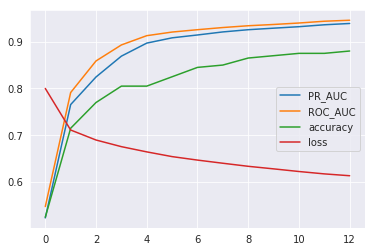

In [22]:
scm_best.metrics['validation'].plot()

We can use the `scoreMetrics` method to calculate a variety of goodness-of-fit metrics.

In [24]:
scm_best.scoreMetrics(d_tr_sc)

,PR_AUC,ROC_AUC,accuracy,loss
0,0.932745,0.933285,0.8325,0.716729


In [23]:
scm_best.scoreMetrics(d_te_sc)

,PR_AUC,ROC_AUC,accuracy,loss
0,0.938827,0.945734,0.88,0.711054


What we notice here is that the test set accuracy (88%) was better than the training set accuracy (83%). This is probably due to noise in the data generation mechanism caused by a relatively small number of observations.

We can also calculate subpopulation-specific goodness-of-fit metrics. Here, `proportion` indicates the proportion of that cadre having `'target' = +1`.

In [27]:
scm_best.scoreMetricsCadre(d_te_sc)

,m,size,proportion,accuracy,ROC_AUC,PR_AUC
0,0,19,0.105263,0.947368,0.941176,0.583333
1,1,14,0.857143,0.857143,0.625000,0.933377
2,2,43,0.813953,0.813953,0.907143,0.980353
3,3,70,0.028571,0.971429,0.897059,0.183333
4,4,43,0.837209,0.860465,0.825397,0.963781
5,5,11,0.545455,0.545455,0.400000,0.521164


We see that most cadres are heavily of one class.